# Frameworks

In [1]:
import pandas as pd
import numpy as np
import time
import pickle
import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

# Pickle Functions

In [2]:
def saveOBJ(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def loadOBJ(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# ML Functions

In [3]:
def calc_log_loss(true,predicted,eps=1e-15):
    if len(true) != len(predicted):
        print("True and predicted values need to be of same shape.")
        return 0

    true = true.astype("float64")
    predicted = predicted.astype("float64")
    
    predicted = np.minimum(np.maximum(predicted,eps),1-eps)
    intermediate = true * np.log(predicted) + (1-true) * np.log(1-predicted)
    score = -np.mean(intermediate)
    return score

def getModelStats(model, testing_data, testing_target):
    test_x = torch.from_numpy(testing_data).float()

    results = model(test_x).detach().numpy()
    results2 = np.round(results)
    error = np.sum(np.abs(results2-testing_target))/len(testing_target)

    log_loss = calc_log_loss(testing_target,results)
    
    return error, log_loss
    
    
def buildSimpleModel(training_data, training_target, testing_data=[], testing_target=[], epochs=4000):
    input_length = training_data.shape[1]
    reporting_at = np.round(epochs/10)
    
    x = torch.from_numpy(training_data).float()
    y = torch.from_numpy(training_target).float()

    model = torch.nn.Sequential(
              torch.nn.Linear(input_length, input_length),
              torch.nn.Softmax(dim=1),
              torch.nn.Linear(input_length, 1),
              torch.nn.Sigmoid()
            )
    loss_fn = torch.nn.MSELoss()
    
    learning_rate = 2e-2
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    errors = []
    loglosses = []
    losses = []
    
    for t in range(epochs+1):
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        if (t) % reporting_at == 0:
            print((t), loss.item())
            
        if len(testing_target) > 0:
            error, logloss = getModelStats(model, testing_data, testing_target)
            errors.append(error)
            loglosses.append(logloss)
            losses.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if len(errors) > 0:
        # Data for plotting
        errors = np.array(errors)
        losses = np.array(losses)

        fig = plt.figure(figsize=(14,9)) 
        ax = fig.gca()
        ax.plot(errors,'r-',losses,'b-')
        ax.set(xlabel='epoch', ylabel='loss & error',
               title='Epochs vs Loss vs Error')
        ax.grid()
        ax.set_ylim([0.0,0.25])
        plt.show()
    return model

def getModelPredictions(model,data):
    x = torch.from_numpy(data).float()
    return model(x).detach().numpy()

# Load Training Data

In [4]:
#df_train = loadOBJ("gen_data/df_test")
df_train = loadOBJ("gen_data/df_train")

In [5]:
df_train.columns

Index(['question1', 'question2', 'is_duplicate', 'tokens1', 'tokens2',
       'firstWordSame', 'firstWordSame_fuzzy', 'lastWordSame',
       'lastWordSame_fuzzy', 'embedding_similarity',
       'embedding_similarity_tfidf', 'word_ratio', 'char_ratio',
       'math_similarity', 'token_similarity', 'token_similarity_idf',
       'cross_correlation', 'cross_correlation_idf', 'q1_degree', 'q2_degree',
       'intersection_count', '2grams', '3grams', '4grams', 'edit_score',
       'jaro_score', 'rel_intersection', 'wl_ratio', 'stop_ratio', 'UC_ratio',
       'why', 'what', 'when', 'where', 'how', 'who',
       'embedding_similarity_max', 'embedding_similarity_max_tfidf',
       'entities1', 'entities2', 'entity_score'],
      dtype='object')

In [6]:
df_train["rel_intersection"] = df_train["intersection_count"]/(df_train["q1_degree"] + df_train["q2_degree"])


In [7]:
pred_columns = ['firstWordSame','firstWordSame_fuzzy','lastWordSame','lastWordSame_fuzzy','embedding_similarity','embedding_similarity_tfidf','word_ratio','char_ratio','math_similarity','token_similarity','token_similarity_idf','cross_correlation','cross_correlation_idf','q1_degree','q2_degree','intersection_count','2grams','3grams','4grams','edit_score','jaro_score','rel_intersection','wl_ratio','stop_ratio','UC_ratio','why','what','when','where','how','who','embedding_similarity_max','embedding_similarity_max_tfidf','entity_score']


In [10]:
df_train[pred_columns].head()

,firstWordSame,firstWordSame_fuzzy,lastWordSame,lastWordSame_fuzzy,embedding_similarity,embedding_similarity_tfidf,word_ratio,char_ratio,math_similarity,token_similarity,...,UC_ratio,why,what,when,where,how,who,embedding_similarity_max,embedding_similarity_max_tfidf,entity_score
id,,,,,,,,,,,,,,,,,,,,,
0,1,1.000000,0,0.268590,0.985097,0.992563,0.857143,0.865385,1,0.944911,...,1.00,1,1,1,1,1,1,0.807135,0.973780,0.000000
1,1,1.000000,0,0.180164,0.896264,0.867497,0.666667,0.549296,1,0.613572,...,1.00,1,1,1,1,1,1,0.841316,0.930674,0.833333
2,1,1.000000,0,0.641304,0.920491,0.892528,0.714286,0.830508,1,0.338062,...,1.00,1,1,1,1,1,1,0.618753,0.637470,0.000000
3,0,0.631337,0,0.167747,0.643019,0.493283,0.846154,0.808511,0,0.000000,...,0.25,0,1,0,1,0,1,0.262062,0.158872,1.000000
4,1,1.000000,0,0.276574,0.828505,0.714578,0.538462,0.524590,1,0.419314,...,1.00,1,1,1,1,1,1,0.506555,0.309699,1.000000


# Add LSTM data

In [11]:
#LSTM_features = pd.read_csv("gen_data/LSTM/1212/test_1_multi_merge_dropout.csv",index_col="test_id")
LSTM_features = pd.read_csv("gen_data/LSTM/1212/train_1_merge_dropout.csv",index_col="id")
LSTM_features.head()

,0
id,
0,0.466974
1,0.007929
2,0.153274
3,0.002511
4,0.010614


In [12]:
pred_columns.extend([x for x in LSTM_features.columns])

df_train = df_train.join(LSTM_features)
df_train[pred_columns].head()

,firstWordSame,firstWordSame_fuzzy,lastWordSame,lastWordSame_fuzzy,embedding_similarity,embedding_similarity_tfidf,word_ratio,char_ratio,math_similarity,token_similarity,...,why,what,when,where,how,who,embedding_similarity_max,embedding_similarity_max_tfidf,entity_score,0
id,,,,,,,,,,,,,,,,,,,,,
0,1,1.000000,0,0.268590,0.985097,0.992563,0.857143,0.865385,1,0.944911,...,1,1,1,1,1,1,0.807135,0.973780,0.000000,0.466974
1,1,1.000000,0,0.180164,0.896264,0.867497,0.666667,0.549296,1,0.613572,...,1,1,1,1,1,1,0.841316,0.930674,0.833333,0.007929
2,1,1.000000,0,0.641304,0.920491,0.892528,0.714286,0.830508,1,0.338062,...,1,1,1,1,1,1,0.618753,0.637470,0.000000,0.153274
3,0,0.631337,0,0.167747,0.643019,0.493283,0.846154,0.808511,0,0.000000,...,0,1,0,1,0,1,0.262062,0.158872,1.000000,0.002511
4,1,1.000000,0,0.276574,0.828505,0.714578,0.538462,0.524590,1,0.419314,...,1,1,1,1,1,1,0.506555,0.309699,1.000000,0.010614


# Add Vector Model Data

In [40]:
#training
vector_model_features1 = pd.read_csv("gen_data/1210/vector1_pred.csv",index_col="id")
vector_model_features2 = pd.read_csv("gen_data/1210/vector2_pred.csv",index_col="id")

In [56]:
#testing
vector_model_features1 = pd.read_csv("gen_data/1210/vector1_test_pred.csv",index_col="test_id")
vector_model_features2 = pd.read_csv("gen_data/1210/vector2_test_pred.csv",index_col="test_id")

In [57]:
df_train = df_train.join(vector_model_features1)
df_train = df_train.join(vector_model_features2)

pred_columns.append("vector1_pred")
pred_columns.append("vector2_pred")

df_train[pred_columns].head()


,firstWordSame,firstWordSame_fuzzy,lastWordSame,lastWordSame_fuzzy,embedding_similarity,embedding_similarity_tfidf,word_ratio,char_ratio,math_similarity,token_similarity,...,when,where,how,who,embedding_similarity_max,embedding_similarity_max_tfidf,entity_score,0,vector1_pred,vector2_pred
test_id,,,,,,,,,,,,,,,,,,,,,
15,0,0.878981,0,0.208558,0.894801,0.826423,0.941176,0.961039,1,0.218218,...,1,1,0,1,0.520753,0.397651,0.5,0.937652,0.060138,0.287481
20,1,1.000000,1,1.000000,0.871040,0.846412,0.714286,0.583333,1,0.507093,...,1,1,1,1,0.743635,0.737955,1.0,0.771405,0.052610,0.286609
21,1,1.000000,0,0.455884,0.948524,0.924701,0.700000,0.789474,1,0.478091,...,1,1,1,1,0.634457,0.749039,1.0,0.077913,0.325333,0.256644
23,0,0.667701,0,0.636073,0.804563,0.559170,0.636364,0.369565,1,0.000000,...,1,0,0,1,0.411248,0.259039,0.0,0.004132,0.006409,0.020942
34,1,1.000000,0,0.200834,0.962578,0.874730,0.750000,0.787879,1,0.866025,...,1,1,1,1,0.803588,0.651903,0.0,0.044044,0.621539,0.745544


## Prepare training - test split

In [22]:
#old

training_cutoff = 270000

training_target = df_train[:training_cutoff]['is_duplicate'].values.reshape((len(df_train[:training_cutoff]), 1))
training_data = df_train[:training_cutoff][pred_columns].values

testing_target = df_train[training_cutoff:]['is_duplicate'].values.reshape((len(df_train[training_cutoff:]), 1))
testing_data = df_train[training_cutoff:][pred_columns].values

In [13]:
#new

training_ids_df = pd.read_csv("gen_data/LSTM/1212/train_id_multiple_merge_dropout.csv")
training_ids = training_ids_df["0"].values

testing_ids_df =  pd.read_csv("gen_data/LSTM/1212/train_val_id_multiple_merge_dropout.csv")
testing_ids = testing_ids_df["0"].values

training_target = df_train.loc[training_ids]['is_duplicate'].values.reshape((len(training_ids), 1))
training_data = df_train.loc[training_ids][pred_columns].values

testing_target = df_train.loc[testing_ids]['is_duplicate'].values.reshape((len(testing_ids), 1))
testing_data = df_train.loc[testing_ids][pred_columns].values

In [8]:
#saveOBJ(training_target,"gen_data/1206/training_target")
#saveOBJ(testing_target,"gen_data/1206/testing_target")

## Prepare full train set

In [42]:
# to dump during training:
dump = [3306,13016,47056,96725,104101,134403,190570,208485,213220,226925,273065,301583,384293,402423]

In [43]:
#training
training_target = df_train.drop(dump)['is_duplicate'].values.reshape((len(df_train.drop(dump)), 1))
training_data = df_train.drop(dump)[pred_columns].values
training_data.shape

(323150, 37)

In [58]:
#testing
training_data = df_train[pred_columns].values
training_data.shape

(81126, 37)

# Training

0 0.2532208263874054
20 0.18365249037742615
40 0.13648585975170135
60 0.10554822534322739
80 0.08779854327440262
100 0.07846435159444809
120 0.07377605140209198
140 0.07154794037342072
160 0.07032927125692368
180 0.06966167688369751
200 0.069241464138031


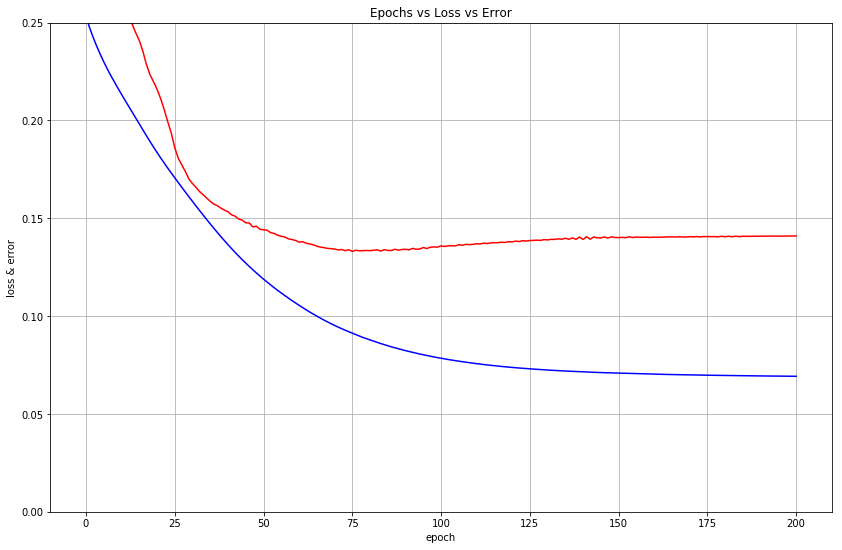

In [14]:
#model = buildSimpleModel(training_data, training_target,epochs=2000)
model = buildSimpleModel(training_data, training_target, testing_data, testing_target, epochs=200)

In [15]:
getModelStats(model, testing_data, testing_target)

(0.1409179989685405, 0.33542533322796164)

### Result without LSTM:

In [ ]:
0 0.2539384961128235
20 0.19166980683803558
40 0.15407398343086243
60 0.13234932720661163
80 0.1210973709821701
100 0.11521043628454208
120 0.11266697943210602
140 0.1111491248011589
160 0.11020985245704651
180 0.10946216434240341
200 0.10881117731332779

(0.15568849922640537, 0.354814091221359)

### Result with LSTM-1

In [ ]:
0 0.24531488120555878
20 0.18516865372657776
40 0.1373331993818283
60 0.10397837311029434
80 0.08731047809123993
100 0.07914263755083084
120 0.07514588534832001
140 0.07309219241142273
160 0.07198093086481094
180 0.07131851464509964
200 0.07088888436555862

(0.14705518308406396, 0.3381960088114185)

### Result with LSTM-16

In [ ]:
0 0.25091782212257385
20 0.16464701294898987
40 0.11585463583469391
60 0.09235018491744995
80 0.08281209319829941
100 0.07814592868089676
120 0.07562693953514099
140 0.07409477978944778
160 0.07300087064504623
180 0.07234574109315872
200 0.0715290829539299

(0.14677668901495616, 0.3482308007360059)

### Result with LSTM-16 plus extra NLP features

In [ ]:
0 0.24379082024097443
20 0.1667856127023697
40 0.11487942188978195
60 0.09125038981437683
80 0.08194547891616821
100 0.07754717022180557
120 0.0753028392791748
140 0.07377737015485764
160 0.07275179773569107
180 0.07198231667280197
200 0.07135581225156784

(0.1468076328004126, 0.34780507299256597)

### Result with LSTM plus extra NLP features, dropout and all data

In [ ]:
0 0.2539590299129486
200 0.08091134577989578
400 0.07817373424768448
600 0.07750551402568817
800 0.0771348774433136
1000 0.07696662843227386
1200 0.07686202228069305
1400 0.07683506608009338
1600 0.0767628476023674
1800 0.07674290239810944
2000 0.07674326747655869

### 1212 Result with 100d LSTM-1 plus extra NLP features

In [ ]:
0 0.24311476945877075
20 0.18525667488574982
40 0.13955077528953552
60 0.1061546728014946
80 0.08653083443641663
100 0.07695663720369339
120 0.07290753722190857
140 0.07114825397729874
160 0.07027234882116318
180 0.06990420818328857
200 0.06948524713516235

(0.14323878287777206, 0.3377844740754635)

### 1212 Result with 100d LSTM-1 plus extra NLP features, dropout and all data

In [ ]:
0 0.25242939591407776
200 0.07875949889421463
400 0.07673019170761108
600 0.07594987004995346
800 0.07558159530162811
1000 0.07539545744657516
1200 0.07527955621480942
1400 0.07520250976085663
1600 0.07514763623476028
1800 0.07509995251893997
2000 0.07545726746320724

### 1212 Result with 100d LSTM-1 plus extra NLP features, dropout and all data and entitiy score

In [ ]:
0 0.2565965950489044
200 0.0783558189868927
400 0.07677897065877914
600 0.07604382932186127
800 0.07575913518667221
1000 0.07559734582901001
1200 0.07550878822803497
1400 0.07550477236509323
1600 0.07534553855657578
1800 0.075312539935112
2000 0.07526924461126328

In [45]:
saveOBJ(model,"gen_data/1213/model_NLP_graphs_vectors_100dLSTM1_dropout_entities")

# Build Predictions

In [59]:
model = loadOBJ("gen_data/1213/model_NLP_graphs_vectors_100dLSTM1_dropout_entities")

In [16]:
predictions = getModelPredictions(model,training_data)
saveOBJ(predictions,"gen_data/1213/model_NLP_graphs_vectors_100dLSTM1_dropout_entities_predictions")

In [17]:
predictions = loadOBJ("gen_data/1213/model_NLP_graphs_vectors_100dLSTM1_dropout_entities_predictions")

In [62]:
df_final = df_train[["q1_degree"]]

In [63]:
for i, value in enumerate(np.round(predictions)):
    df_final.iloc[i]["q1_degree"] = value

In [64]:
df_final["q1_degree"] = df_final["q1_degree"].astype(int)

/Users/floris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
df_final = df_final.rename(columns={'q1_degree': 'is_duplicate'})

In [66]:
df_final.loc[[20072,20794,189659,254161]] = 0

In [67]:
df_final.head()

,is_duplicate
test_id,
15,1
20,1
21,0
23,0
34,0


In [68]:
len0 = len(df_final[df_final["is_duplicate"] == 0])
len1 = len(df_final[df_final["is_duplicate"] == 1])
ratio = len0/(len0+len1)
print(ratio)
print(1-ratio)

0.6306116411508025
0.3693883588491975


In [69]:
df_final.to_csv('gen_data/submission_model_NLP_graphs_vectors_100dLSTM1_dropout_entities.csv')

# Check faults

In [78]:
predictions = getModelPredictions(model,testing_data)

In [79]:
df_compare = df_train.loc[testing_ids][["question1","question2","is_duplicate","entity_score"]]

In [80]:
df_compare['prediction'] = pd.Series(np.round(predictions.reshape(len(predictions))), index=df_compare.index).astype(int)


In [81]:
B = df_compare[df_compare["prediction"] == df_compare["is_duplicate"]]
C = df_compare[df_compare["prediction"] != df_compare["is_duplicate"]]
print(len(df_compare))
print(len(B))
print(len(C))
print(len(B)/(len(B)+len(C)))

96950
83288
13662
0.8590820010314595


In [85]:
i = 0
for index, row in C.iterrows():
    print(row["question1"])
    print(row["question2"])
    print(row["is_duplicate"])
    print()
    i+=1
    if i> 100:
        break

What was getting your first tattoo like?
How would you describe the experience of getting your first tattoo?
1

Does cannabis/marijuana protect against excitotoxicity, in general?
Does marijuana treat epilepsy?
0

What are the most common lies told by spouses?
What are the most common lies told by husbands?
1

Who are the young (under 30 year old) rising stars in Physics?
Who are the young (under 30 years old) rising stars in mathematics?
0

Who can become the next President of India and why?
Who do you think will be the best choice for India's next president after Pranab Mukherjee?
0

Which is the best cricketer?
Which is best cricketer all over?
1

How do you cook Pangasius?
How do you cook striped Pangasius?
1

How good was the surgical strike by Indian Army on terror camps at PoK?
What are the solid evidences of surgical strikes done by the Indian Army in PoK?
0

What is varicocele erectile dysfunction? How can this be treated?
How is erectile dysfunction treated?
0

How can i get 